In [75]:
"""
Goal: Develop a line search algorithm using:
                - steepest descent
                - quasi Newton Method

Validation: Use the following test cases from the book:
                -  D.1.1 (a quadratic function)
                -  D.1.2 (Rosenbrock)
                -  D.1.3 (The bean function we’ve been exploring)
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [76]:
# Validation Functions
def f_quadratic(x):
    # Global minimum: 0.0 at (0,0)
    beta = 3/2
    return x[0]**2 + x[1]**2 - beta*x[0]*x[1]
def fd_quadratic(x):
    beta = 3/2
    return np.array([2*x[0] - beta*x[1], 2*x[1]-beta*x[0]])# .reshape([-1,1])


def f_rosenbrock(x):
    # Global minimum: 0.0 at (1,1)
    return (1-x[0])**2 + 100*(x[1] - x[0]**2)**2
def fd_rosenbrock(x):
    return np.array([2*(x[0] - 1) - 400*x[0]*(x[1]-x[0]**2), 200*(x[1]-x[0]**2)])# .reshape([-1,1])


def f_bean(x):
    # Global Minimum: 0.09194 at x = (1.21314, 0.82414)
    return (1-x[0])**2 + (1-x[1])**2 + 0.5*(2*x[1] - x[0]**2)**2
def fd_bean(x):
    return np.array([2*(x[0] - 1) - 2*x[0]*(2*x[1] - x[0]**2), 2*(x[1] - 1) + 2*(2*x[1] - x[0]**2)])# .reshape([-1,1])


def plot_function(f, x0, xf, zoom=100, res=None):
    n1 = 100
    n2 = 99
    x1 = np.linspace(x0[0], xf[0], n1)
    x2 = np.linspace(x0[1], xf[1], n2)

    fun = np.zeros([n1,n2])

    # function evaluations for the contour plot
    for i in range(n1):
        for j in range(n2):
            fun[i,j] = f([x1[i],x2[j]]) 

    # plotting
    fig, ax = plt.subplots()
    ax.contour(x1, x2, np.transpose(fun), zoom)
    if res != None:
        ax.plot(res.x[0],res.x[1],'r*')
    return ax

# plot_function(f_simple, (-5, -5), (5, 5), 20)
# plot_function(f_quadratic, (-10, -8), (10, 8), 20)
# plot_function(f_rosenbrock, (-1.5, -1), (1.5, 3), 100)
# plot_function(f_bean, (-2, -1), (4, 3), 100)

In [77]:
"""
Line Search Algorithm
    Inputs: 
        - x_k: value of x that is being used to evaluate the objective function
        - f: f(x_k + alpha*p_k) = phi(alpha) where f is the objective function
        - grad: grad(x_k + alpha*p_k).T @ p_k where grad is the derivative of the objective function
        - alpha_init (> 0): initial step size
        - mu_1 (0 < mu_1 < 1): sufficient decrease factor
        - mu_2 (mu_1 < mu_2 < 1): sufficient curvature factor
        - sigma (sigma > 1): step size increase factor
        - plot: whether or not to plot pinpointing steps
    Outputs:
        - alpha_star: acceptable step size (satisfies the strong Wolfe conditions)
"""

def bracket_line_search(x_k, f, grad, alpha_init, p_k, mu_1, mu_2, sigma, plot=False):
    # Define the initial bracket
    a1 = 0
    a2 = alpha_init
    calls = 0

    # Used in pinpoint
    phi0 = f(x_k)
    calls += 1
    phid0 = grad(x_k).T @ p_k
    first = True

    while True:
        phi1 = f(x_k + a1*p_k)
        phi2 = f(x_k + a2*p_k)
        calls += 2
        if (phi2 > (phi0 + mu_1*a2*phid0)) or (not first and phi2 > phi1):
            return pinpoint(calls, a1, a2, p_k, x_k, f, grad, phi0, phid0, mu_1, mu_2, plot=plot) # 1 is lower and 2 is higher

        phid2 = grad(x_k + a2*p_k).T @ p_k
        if np.abs(phid2) <= -mu_2*phid0:
            return a2, calls
        elif phid2 >= 0:
            return pinpoint(calls, a2, a1, p_k, x_k, f, grad, phi0, phid0, mu_1, mu_2, plot=plot) # 2 is lower and 1 is higher 
        else:
            a1 = a2
            a2 *= sigma
        first = False
# ==========================================================================================================

"""
Pinpoint function for line search Algorithm
    Inputs: 
        - calls: current number of functions calls in this line search 
        - alpha_low: interval endpoint with lower function value
        - alpha_high: interval endpoint with higher function value
        - p_k: search direction
        - x_k: current optimization value
        - f: f(x_k + alpha*p_k) = phi(alpha) where f is the objective function
        - grad: grad(x_k + alpha*p_k).T @ p_k where grad is the derivative of the objective function
        - phi_0, phi_d0: computed in outer routine, pass in to save function call
        - mu_1 (0 < mu_1 < 1): sufficient decrease factor
        - mu_2 (mu_1 < mu_2 < 1): sufficient curvature factor
        - plot: whether or not to plot pinpointing steps
    Outputs:
        - alpha_star: step size satisfying the strong Wolfe conditions
"""
def pinpoint(calls, alpha_low, alpha_high, p_k, x_k, f, grad, phi0, phid0, mu_1, mu_2, plot=False):
    k = 0
    while True:
        phi_low = f(x_k + alpha_low*p_k)
        phi_dlow = grad(x_k + alpha_low*p_k).T @ p_k
        phi_high = f(x_k + alpha_high*p_k)
        phi_dhigh = grad(x_k + alpha_high*p_k).T @ p_k

        alpha_p = interpolate(alpha_low, alpha_high, phi_low, phi_high, phi_dlow, phi_dhigh)
        phi_p = f(x_k + alpha_p*p_k)
        phi_dp = grad(x_k + alpha_p*p_k).T @ p_k

        calls += 3         # 3 function calls to this point

        if plot:
            fig, axis = plt.subplots()
            axis.plot(alpha_low, phi_low, 'bo')             # alpha_low will be a blue circle
            axis.plot(alpha_high, phi_high, 'ro')            # alpha_high will be red circle
            axis.plot(alpha_p, phi_p, 'v')            # alpha_p will be a triangle

        if (phi_p > phi0 + mu_1*alpha_p*phid0) or (phi_p > phi_low):
            alpha_high = alpha_p
        else:
            if np.abs(phi_dp) <= -mu_2*phid0:
                return alpha_p, calls
            elif phi_dp*(alpha_high - alpha_low) >= 0:
                alpha_high = alpha_low
            alpha_low = alpha_p
        k += 1
# ==========================================================================================================

"""
interpolate is a helper for the pinpoint function to find a better point within the interval
"""
def interpolate(alpha_1, alpha_2, phi_1, phi_2, phi_d1, phi_d2):
    beta_1 = phi_d1 + phi_d2 - 3 * (phi_1 - phi_2) / (alpha_1 - alpha_2)
    beta_2 = np.sign(alpha_2 - alpha_1) * np.sqrt(beta_1**2 - phi_d1*phi_d2)

    alpha_p = alpha_2 - (alpha_2 - alpha_1) * (phi_d2 + beta_2 - beta_1) / (phi_d2 - phi_d1 + 2*beta_2)

    if ((alpha_p < alpha_1 or alpha_p > alpha_2) and (alpha_2 > alpha_1)) or \
                ((alpha_p > alpha_1 or alpha_p < alpha_2) and (alpha_2 < alpha_1)):
        # If alpha_p is outside the interval, just do bisection
        alpha_p = (alpha_1 + alpha_2) / 2
    
    return alpha_p

In [78]:
"""
Steepest Descent Search Direction
    Inputs: 
        - f: function to be minimized
        - grad: derivative of the function to be minimized
        - function name: name of the function to be minimized, used in plot titles
        - x0: starting point
        - a_init: initial step size
        - mu_1: sufficient decrease condition
        - mu_2: sufficient curvature condition
        - sigma: bracket growth factor
        - tau: convergence tolerance
        - max_iter: maximum iterations for line search to run
        - plot_steps: whether or not the plot x_k at each iteration
        - plot_convergence: whether to plot the convergence plot for the run
        - print_: print the details of the optimization at the end
        - plot_pinpointing: whether or not to plot the pinpointing algorithm among other details

    Outputs:
        - x_star: optimal point
        - f_x_star: minimum function value
        - calls: number of function calls made during the optimization
"""

def steepest_descent(f, grad, function_name, x0, a_init=1, mu_1=1e-4, mu_2=0.75, sigma=2, tau=1e-6, max_iter=200, plot_steps=None, plot_convergence=False, print_=False, plot_pinpointing=False):
    k = 0
    func_calls = 0
    x_k = x0
    df = grad(x_k)
    df_1 = df

    if plot_steps != None:
        x1_hist = []
        x2_hist = []
        # Initial point is red
        x1_hist.append(x_k[0])
        x2_hist.append(x_k[1])

    if plot_convergence:
        convergence_hist = []
        
    while np.linalg.norm(df, ord=np.Inf) > tau and k < max_iter:
        # get the step direction
        p_k = np.reshape((-df/np.linalg.norm(df)),(2,))
        
        # Find initial step size
        if k == 0:
            alpha_init = a_init
        else:
            alpha_init = alpha_k * (df_1.T @ p_k1) / (df.T @ p_k)

        alpha_k, calls = bracket_line_search(x_k, f, grad, alpha_init, p_k, mu_1, mu_2, sigma, plot=plot_pinpointing)
        func_calls += calls
        x_k = x_k + alpha_k*p_k # step in the new direction

        if plot_steps != None:
            x1_hist.append(x_k[0])
            x2_hist.append(x_k[1])

        if plot_convergence:
            convergence_hist.append(np.linalg.norm(df))

        # For next iteration
        df_1 = df
        df = grad(x_k) # calculate derivative to be able to have only one function call
        p_k1 = p_k
        k += 1

    if plot_steps != None:
        plot_steps.plot(x1_hist, x2_hist, 'bo-')              # plot all optimization points
        plot_steps.plot(x1_hist[0], x2_hist[0], 'ro')         # Initial point is red
        plot_steps.plot(x1_hist[-1], x2_hist[-1], 'go')       # last point is green
        plt.title(f'Convergence Plot for Steepest Descent on {function_name} Function')

    if print_:
        print(f'Optimization finished in {k} iterations for the {function_name} function. \nx* = {x_k} \nf(x*) = {f(x_k)}\nStopping Condition: {np.linalg.norm(df, ord=np.Inf)}\nFunction Calls: {func_calls}\n')

    if plot_convergence:
        plt.figure()
        plt.plot(convergence_hist)
        plt.xlabel('Iteration')
        plt.ylabel('Magnitude of df')
        plt.title(f'Convergence Plot for Steepest Descent on {function_name} Function')
        plt.show()

    return x_k, f(x_k), func_calls

In [79]:
"""
BFGS Search Direction
    Inputs: 
        - f: function to be minimized
        - grad: derivative of the function to be minimized
        - function_name: name of the function to be minimized, used in plotting
        - x0 starting point
        - a_init: initial step size
        - mu_1: sufficient decrease condition
        - mu_2: sufficient curvature condition
        - sigma: bracket growth factor
        - tau: convergence tolerance
        - max_iter: maximum iterations for line search to run
        - plot_steps: whether or not the plot x_k at each iteration
        - plot_verbose: whether or not to print the pinpointing algorithm among other details
        - print_: print the details of the optimization at the end
    Outputs:
        - x*: optimal point
        - f*(x*): minimum function value
        - calls: number of function calls made during the optimization

        
"""

def bfgs(f, grad, function_name, x0, a_init=1, mu_1=1e-4, mu_2=0.75, sigma=2, tau=1e-6, max_iter=200, plot_steps=None, plot_convergence=False, print_=False, plot_pinpointing=False):
    k = 0
    func_calls = 0
    x_k = x0

    df = grad(x_k)
    df_1 = df
    reset_threshold = 10

    if plot_steps != None:
        x1_hist = []
        x2_hist = []
        # Initial point is red
        x1_hist.append(x_k[0])
        x2_hist.append(x_k[1])

    if plot_convergence:
        convergence_hist = []
        

    while np.linalg.norm(df, ord=np.Inf) > tau and k < max_iter:
        if k == 0 or df.T@p_k > reset_threshold:
            V_k = (1/np.linalg.norm(df)) * np.eye(2)
        else:
            s = np.reshape(x_k - x_k1, (2,1))
            y = np.reshape(df - df_1, (2,1))
            sigma_ = 1/(s.T @ y)
            # V_k = (np.eye(2) - sigma_ @ s @ y.T) @ V_k1 @ (np.eye(2) - sigma_ @ y @ s.T) + (sigma_ @ s @ s.T)
            V_k = (np.eye(2) - sigma_ * s @ y.T) @ V_k1 @ (np.eye(2) - sigma_ * y @ s.T) + (sigma_ * s @ s.T)


        p_k = np.reshape(-V_k @ df, (2,))
        alpha_k, calls = bracket_line_search(x_k, f, grad, a_init, p_k, mu_1, mu_2, sigma, plot=plot_pinpointing)
        x_k1 = x_k
        x_k = x_k + alpha_k * p_k 

        func_calls += calls
        k += 1

        if plot_steps != None:
            x1_hist.append(x_k[0])
            x2_hist.append(x_k[1])

        if plot_convergence:
            convergence_hist.append(np.linalg.norm(df))
        # For next iteration
        V_k1 = V_k
        df_1 = df
        df = grad(x_k) # calculate derivative to be able to have only one function call

    if plot_steps != None:
        plot_steps.plot(x1_hist, x2_hist, 'bo-')
        plot_steps.plot(x1_hist[0], x2_hist[0], 'ro')        # Initial point is red
        plot_steps.plot(x1_hist[-1], x2_hist[-1], 'go')        # last point is green
        plt.title(f'Convergence Plot for BFGS on {function_name} Function')

    if print_:
        print(f'Optimization finished in {k} iterations. \nx* = {x_k} \nf(x*) = {f(x_k)}\nStopping Condition: {np.linalg.norm(df, ord=np.Inf)}\nFunction Calls: {func_calls}\n')

    if plot_convergence:
        plt.figure()
        plt.plot(convergence_hist)
        plt.xlabel('Iteration')
        plt.ylabel('Magnitude of df')
        plt.title(f'Convergence Plot for BFGS on {function_name} Function')
        plt.show()
        
    return x_k, f(x_k), func_calls

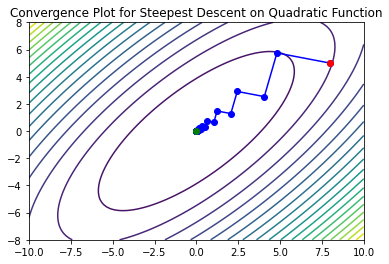

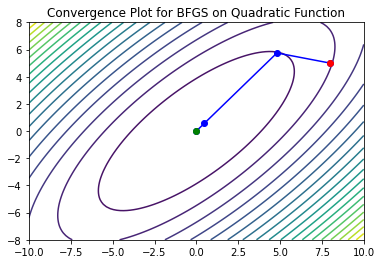

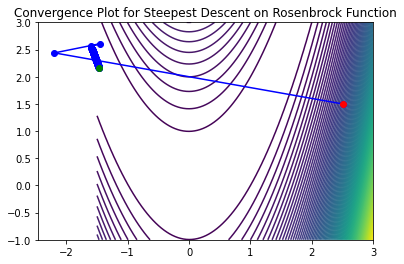

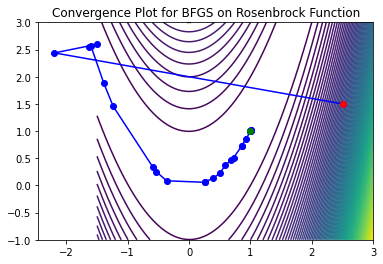

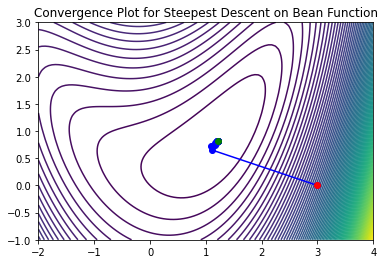

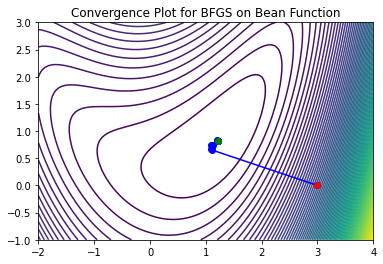

In [80]:
def test_optimizers(initial_cond, mode='fn_calls', print_=False):
   
    if mode == 'fn_calls':
        # Steepest Descent
        sd_x_k_quadratic, sd_f_value_quadratic, sd_calls_quadratic = steepest_descent(f_quadratic, fd_quadratic, 'Quadratic', initial_cond[0], a_init=12)
        sd_x_k_rosen, sd_f_value_rosen, sd_calls_rosen = steepest_descent(f_rosenbrock, fd_rosenbrock, 'Rosenbrock', initial_cond[1], a_init=10)
        sd_x_k_bean, sd_f_value_bean, sd_calls_bean = steepest_descent(f_bean, fd_bean, 'Bean', initial_cond[2], a_init=2)

        # # BFGS (Quasi-Newton)
        qn_x_k_quadratic, qn_f_value_quadratic, qn_calls_quadratic = bfgs(f_quadratic, fd_quadratic, 'Quadratic', initial_cond[0], a_init=12)
        qn_x_k_rosen, qn_f_value_rosen, qn_calls_rosen = bfgs(f_rosenbrock, fd_rosenbrock, 'Rosenbrock', initial_cond[1], a_init=10)
        qn_x_k_bean, qn_f_value_bean, qn_calls_bean = bfgs(f_bean, fd_bean, 'Bean', initial_cond[2], a_init=2)

        # # Scipy Optimizer with provided gradients
        sp_quad_res = minimize(f_quadratic, initial_cond[0], jac=fd_quadratic, tol=1e-6) # objective, initial conditions, etc.
        sp_rosen_res = minimize(f_rosenbrock, initial_cond[1], jac=fd_rosenbrock, tol=1e-6) # objective, initial conditions, etc.
        sp_bean_res = minimize(f_bean, initial_cond[2], jac=fd_bean, tol=1e-6) # objective, initial conditions, etc.

        # Scipy Optimizer with provided gradients
        # sp_quad_res = minimize(f_quadratic, initial_cond[0], tol=1e-6) # objective, initial conditions, etc.
        # sp_rosen_res = minimize(f_rosenbrock, initial_cond[1], tol=1e-6) # objective, initial conditions, etc.
        # sp_bean_res = minimize(f_bean, initial_cond[2], tol=1e-6) # objective, initial conditions, etc.

        print(f'Function Calls for Quadratic Function->   SD: {sd_calls_quadratic}, bfgs: {qn_calls_quadratic}, scipy: {sp_quad_res.nfev}')
        print(f'Function Calls for Rosenbrock Function->  SD: {sd_calls_rosen}, bfgs: {qn_calls_rosen}, scipy: {sp_rosen_res.nfev}')
        print(f'Function Calls for Bean Function->        SD: {sd_calls_bean}, bfgs: {qn_calls_bean},  scipy: {sp_bean_res.nfev}')
        print()

    elif mode == 'convergence':
        # Steepest Descent
        sd_x_k_quadratic, sd_f_value_quadratic, sd_calls_quadratic = steepest_descent(f_quadratic, fd_quadratic, 'Quadratic', initial_cond[0], a_init=12, plot_convergence=True)
        qn_x_k_quadratic, qn_f_value_quadratic, qn_calls_quadratic = bfgs(f_quadratic, fd_quadratic, 'Quadratic', initial_cond[0], a_init=12, plot_convergence=True)

        sd_x_k_rosen, sd_f_value_rosen, sd_calls_rosen = steepest_descent(f_rosenbrock, fd_rosenbrock, 'Rosenbrock', initial_cond[1], a_init=10, plot_convergence=True)
        qn_x_k_rosen, qn_f_value_rosen, qn_calls_rosen = bfgs(f_rosenbrock, fd_rosenbrock, 'Rosenbrock', initial_cond[1], a_init=10, plot_convergence=True)

        sd_x_k_bean, sd_f_value_bean, sd_calls_bean = steepest_descent(f_bean, fd_bean, 'Bean', initial_cond[2], a_init=2, plot_convergence=True)
        qn_x_k_bean, qn_f_value_bean, qn_calls_bean = bfgs(f_bean, fd_bean, 'Bean', initial_cond[2], a_init=2, plot_convergence=True)

    elif mode == 'iteration_path':
        quad_ax_sd = plot_function(f_quadratic, (-10, -8), (10, 8), 20)
        sd_x_k_quadratic, sd_f_value_quadratic, sd_calls_quadratic = steepest_descent(f_quadratic, fd_quadratic, 'Quadratic', initial_cond[0], a_init=12, print_=print_, plot_steps=quad_ax_sd)
        quad_ax_bfgs = plot_function(f_quadratic, (-10, -8), (10, 8), 20)
        qn_x_k_quadratic, qn_f_value_quadratic, qn_calls_quadratic = bfgs(f_quadratic, fd_quadratic, 'Quadratic', initial_cond[0], a_init=12, print_=print_, plot_steps=quad_ax_bfgs)

        rosen_ax_sd = plot_function(f_rosenbrock, (-1.5, -1), (3, 3), 100)
        sd_x_k_rosen, sd_f_value_rosen, sd_calls_rosen = steepest_descent(f_rosenbrock, fd_rosenbrock, 'Rosenbrock', initial_cond[1], a_init=10, print_=print_, plot_steps=rosen_ax_sd)
        rosen_ax_bfgs = plot_function(f_rosenbrock, (-1.5, -1), (3, 3), 100)
        qn_x_k_rosen, qn_f_value_rosen, qn_calls_rosen = bfgs(f_rosenbrock, fd_rosenbrock, 'Rosenbrock', initial_cond[1], a_init=10, print_=print_, plot_steps=rosen_ax_bfgs)

        bean_ax_sd = plot_function(f_bean, (-2, -1), (4, 3), 100)
        sd_x_k_bean, sd_f_value_bean, sd_calls_bean = steepest_descent(f_bean, fd_bean, 'Bean', initial_cond[2], a_init=2, print_=print_, plot_steps=bean_ax_sd)
        bean_ax_bfgs = plot_function(f_bean, (-2, -1), (4, 3), 100)
        qn_x_k_bean, qn_f_value_bean, qn_calls_bean = bfgs(f_bean, fd_bean, 'Bean', initial_cond[2], a_init=2, print_=print_, plot_steps=bean_ax_bfgs)




initial_conds1 = [np.array([8, 5]), np.array([2.5, 1.5]), np.array([3, 0])]
initial_conds2 = [np.array([8, -5]), np.array([1.0, -.5]), np.array([0, 2.5])]
initial_conds3 = [np.array([-5, 5]), np.array([0.0, 0.0]), np.array([-1, -0.5])]
initial_conds4 = [np.array([-5, -2]), np.array([0.0, 2.5]), np.array([3, 2.5])]

test_optimizers(initial_cond=initial_conds1, mode='iteration_path')
# test_optimizers(initial_cond=initial_conds2, mode='fn_calls')
# test_optimizers(initial_cond=initial_conds3, mode='fn_calls')
# test_optimizers(initial_cond=initial_conds4, mode='fn_calls')